In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,t,uniform,f
from sklearn.linear_model import LinearRegression
import termcolor
from numba import jit

def rprint(string):
    print(termcolor.colored(string, color='green'))

In [2]:
##njit compile

@jit(fastmath=True,parallel=True,inline='always')
def linear_regression_numba(X, y):
    X_with_intercept = np.column_stack((np.ones(X.shape[0]), X))
    theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y
    return theta

@jit(fastmath=True)
def RSS(X, model):
    ret=0
    for i in X:
        ret+=(i[:-1]@model[1:].T+model[0]-i[-1])**2
    return ret

@jit(fastmath=True,parallel=True,nogil=True)
def getdeltas(X, bsN):
    deltai = np.zeros((bsN, 6))
    рэсэсы = np.zeros(bsN)
    n_samples = len(X)
    
    for i in range(bsN):
        indices = np.random.randint(0, n_samples, size=n_samples)
        X0 = X[indices]
        X_features = X0[:, :5]
        y = X0[:, -1]
        deltai[i] = linear_regression_numba(X_features, y)
        рэсэсы[i] = RSS(X, deltai[i])
    deltai=deltai.T
    deltai=np.sort(deltai)
    рэсэсы=np.sort(рэсэсы)
    return deltai,рэсэсы


def normal_bs(sgm, bsN):
    нормисы = np.zeros(bsN)
    нормисы = np.random.normal(0, sgm, bsN)
    нормисы=np.sort(нормисы)
    return нормисы

def TSS(X):
    ret=np.sum((X[:,-1]-np.sum(X[:,-1])/len(X))**2)
    return ret


In [3]:
def generate(N):
    ret = np.array([np.zeros(6) for i in range(N)])
    _=uniform(loc=-1, scale=2)
    for i in range(N):
        ret[i,:5]=_.rvs(size=5)
        x1,x2,x3,x4,x5=ret[i,:5]
        ret[i,5]=np.random.normal(2+3*x1-2*x2+x3+x4-x5, 1.5)
        print(*[round(i,2) if i<0 else "+"+str(round(i,2)) for i in ret[i]],sep="\t")
    return ret

In [4]:
N=50
X=generate(N)

-0.01	+0.91	+0.36	+0.68	+0.53	+0.54
+0.25	+0.7	-0.74	-0.46	+0.58	-1.07
+0.5	+0.31	-0.28	-0.74	+0.95	-0.03
-0.4	-0.94	-0.06	-0.26	-0.29	+1.52
+0.61	-0.6	-0.05	-0.92	-0.65	+5.95
-0.09	-0.02	-0.98	+0.08	-0.67	+0.92
+0.78	+0.56	+0.14	+0.23	+0.93	-1.14
-0.21	+0.63	-0.35	+0.68	+0.31	+1.19
-0.54	-0.21	-0.45	+0.72	-0.54	+0.66
-0.55	-0.48	-0.47	-0.89	+0.21	+0.29
+0.85	-0.76	+0.13	-0.09	+0.72	+7.76
-0.99	-0.12	-0.57	+0.59	-0.47	+1.31
+0.51	-0.6	-0.47	-0.92	-0.02	+3.16
-0.53	-0.55	+0.6	+0.81	-0.58	+6.37
+0.89	-0.28	+0.2	+0.85	-0.21	+7.94
-0.13	+0.08	+0.92	-0.59	+0.9	+1.34
+0.12	-0.74	+0.94	-0.14	-0.98	+7.9
-0.61	-0.14	+0.44	-0.93	+0.27	-0.81
+0.81	-0.69	-0.36	+0.58	-0.42	+5.78
-0.5	+0.45	+0.01	+0.13	+0.77	-0.18
+0.69	+0.09	-0.81	-0.67	+0.75	+1.77
+0.95	-0.99	-0.49	-0.52	+0.49	+5.93
+0.78	-0.65	-0.35	-0.74	+0.36	+1.23
+0.39	+0.24	+0.82	-0.73	+0.21	+2.04
-0.98	-0.14	-0.32	+0.55	+0.05	+1.2
-0.7	-0.77	-0.21	+0.26	-0.09	+3.34
+0.93	-0.52	-0.82	-0.63	-0.18	+3.88
-0.65	-0.5	+0.33	-0.45	-0.48	+3.96
-0.16

In [5]:
nonetha = np.ones(X.shape)
nonetha[:,1:] = X[:,:5]
nonetha[:,0] = 1
F = nonetha.T.dot(nonetha)
#print(F)
rprint(f"a) не являются\n|F| = {round(np.linalg.det(F),2)} >> 1")

a) не являются
|F| = 53102520.8 >> 1


In [6]:
model = linear_regression_numba(nonetha[:,1:], X[:,-1])
model

/tmp/ipykernel_27812/4170485442.py:6: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y


array([ 2.40919535,  2.97402698, -2.55357499,  1.04826117,  1.96380455,
       -1.55819162])

$ H_0:B_i=0 $

$ H_1:B_i\neq0 $

## $ \Delta=\frac{B_i}{(RSS \cdot F_{ii}^{-1})}\sqrt{n-p} \sim t(n-p) $

In [7]:
F_1=np.linalg.inv(F)
Rss=RSS(X, model)
delta = model/np.sqrt(Rss*F_1.diagonal())*(N-6)**0.5
print(t.sf(delta,N-6))
rprint("b) значимость определяется на генерацию")
rprint("   β_i:"+str(model)[1:-2])
i=7
#print(np.array(model[1:]).dot(nonetha[i])+model[0], X[i,-1])

[8.36461294e-15 8.51386831e-13 9.99999994e-01 3.12502446e-03
 2.99648295e-07 9.99836825e-01]
b) значимость определяется на генерацию
   β_i: 2.40919535  2.97402698 -2.55357499  1.04826117  1.96380455 -1.5581916


/tmp/ipykernel_27812/4170485442.py:13: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  ret+=(i[:-1]@model[1:].T+model[0]-i[-1])**2


In [8]:
bsN=5000
deltas,ы=getdeltas(X, bsN)
b = 0.95
alf = (1-b)/2
k1 = int(alf*bsN)
k2 = bsN-k1

/tmp/ipykernel_27812/4170485442.py:6: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y


### $ H_0:\forall i \to B_i\neq0 $

### $ H_1:\exists j \to B_j=0 $

## $ \Delta=\frac{\frac{TSS-RSS}{p-1} }{\frac{RSS}{n-p} }\sqrt{n-p} \sim F(p-1,n-p)$

In [9]:
Rss,Tss=RSS(X,model),TSS(X)

_=1-Rss/Tss
rprint(f"c) {_}")
_1,_2=1-ы[k1]/TSS(X),1-ы[k2]/TSS(X)
rprint(f"""   R^2 {"" if _2<_<_1 else "не"} попадает в доверительный интервал BS (на всякий случай)
   ({round(_2,5)}, {round(_1,5)})\n""")
delta = (Tss-Rss)/5/(Rss/(N-6))
pval=f.sf(delta,5,N-6)
rprint(f"   {pval=}\n   Отвергаем H0 =>...=> не значим")

c) 0.8335950506551435
   R^2 не попадает в доверительный интервал BS (на всякий случай)
   (0.77025, 0.82905)

   pval=np.float64(4.77162270259374e-16)
   Отвергаем H0 =>...=> не значим


In [10]:
rprint(f"d) при x_k==0 значение будет {round(model[0],4)}")
rprint(f"   доверительный интервал: ({round(deltas[0,k1],4)}, {round(deltas[0,k2],4)})")

d) при x_k==0 значение будет 2.4092
   доверительный интервал: (1.9741, 2.8139)


# $ \Delta=\frac{I_n-\frac{n(n-1)}{4} }{\sqrt{\frac{n^3}{36} } } \sim F(p-1,n-p)$

In [11]:
e = [i[:-1]@model[1:].T+model[0]-i[-1] for i in X]
In=0
for i in range(len(X)):
    for j in range(i+1,len(X)):
        In+=e[i]<e[j]

delta = (In-N*(N-1)/4)/(N**3/36)**0.5
pval=norm.sf(delta)

rprint(f"e) {pval=}\n   Не отвергаем H0 => независимы")

e) pval=np.float64(0.709369350034898)
   Не отвергаем H0 => независимы


In [12]:
#Калмогоров
bsN=100000
sgm = Rss/(N-6)
sgm
deltas=normal_bs(sgm,bsN)
pval=np.where((deltas)*N**0.5 > np.max(e))[0][0]/bsN
rprint(f"f) {pval=}\n   Не отвергаем H0 => Распределено нормально")

f) pval=np.float64(0.60324)
   Не отвергаем H0 => Распределено нормально


g) Выбросов нет


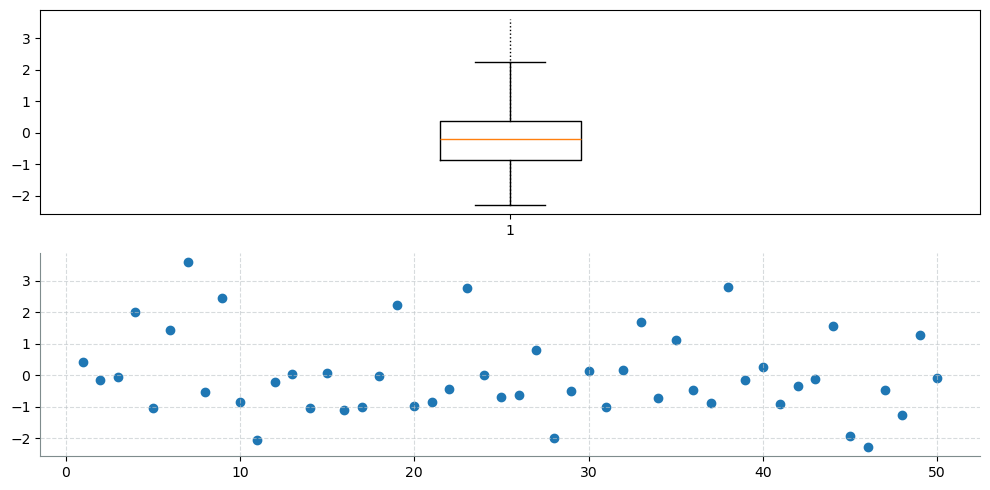

In [13]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
rprint("g) Выбросов нет") #FIXME


e1 = np.sort(e)
ax1.plot([1,1],[e1[3*N//4],e1[-1]],linestyle='dotted',linewidth=1, color="black")
ax1.plot([1,1],[e1[0],e1[N//4]],linestyle='dotted',linewidth=1, color="black")
box=ax1.boxplot(e1,showfliers=False)
ax2.scatter([i+1 for i in range(N)],e)
plt.grid(True, linestyle='--', alpha=0.6, color='#bdc3c7')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#7f8c8d')
ax.spines['bottom'].set_color('#7f8c8d')

plt.tight_layout()


In [14]:
CUSS=0
for i in range(len(X)):
    X0=X[[j!=i for j in range(len(X))]]
    model_=linear_regression_numba(X0[:,:-1], X0[:,-1])
    p=X[i]
    CUSS+=(p[:-1]@model_[1:].T+model_[0]-p[-1])**2
rprint(f"h) CUSS = {float(CUSS)}")
rprint(f"   R_cu^2 = {(Tss-CUSS)/Tss}\n   предсказательная способность есть(не нулевая)")


h) CUSS = 110.64894106748054
   R_cu^2 = 0.7844355978351499
   предсказательная способность есть(не нулевая)


## $ \tilde{\delta_1^2}=\frac{1}{l-1} \sum_{i=1}^l {( y_i-\bar{y} )}^2 $

# $ \Delta=\frac{\frac{RSS}{n-p} }{ \tilde{\delta_1^2} } \sim F(n-p,l-1)$

In [15]:
p=X[np.random.randint(N)]
sgm2=5/4*((np.mean(X[:,-1])-p[-1])**2)
delta = Rss/(N-6)/sgm2
pval=f.sf(delta,N-6,5-1)

rprint(f"""i) pval={float(pval)}\n   {"" if pval<0.05 else "не"} отвергаем H0 =>
                    (Модель {"не" if pval<0.05 else ""}адекватна)""")

i) pval=0.9999999999250974
   не отвергаем H0 =>
                    (Модель адекватна)


In [16]:
def Покупка_обезьяны():
    return "-100руб"

def Запрос_alf_от_обезьяны(mx):
    return np.random.rand()*mx

def Обезьяна_гений_знак_вопроса(delta, alf):
    return len(np.where(delta>alf)[0])==1

def Продажа_обезьяны():
    return "+105руб"

delta = model/np.sqrt(Rss*F_1.diagonal())*(N-6)**0.5
pvals=t.sf(delta,N-6)
alf=0
while(True):
    Покупка_обезьяны()
    alf = Запрос_alf_от_обезьяны(np.max(pvals))
    if Обезьяна_гений_знак_вопроса(pvals, alf):
        break
    Продажа_обезьяны()

print(pvals)
print(alf)

[8.36461294e-15 8.51386831e-13 9.99999994e-01 3.12502446e-03
 2.99648295e-07 9.99836825e-01]
0.9998632931464362


In [17]:
Xdel=np.delete(X,np.where(pvals>alf)[0],1)

nonethadel = np.ones(Xdel.shape)
nonethadel[:,1:] = Xdel[:,:4]
nonethadel[:,0] = 1
Fdel = nonethadel.T.dot(nonethadel)

modeldel = linear_regression_numba(nonethadel[:,1:], Xdel[:,-1])

Fdel_1=np.linalg.inv(Fdel)
Rssdel=RSS(Xdel, modeldel)
deltadel = modeldel/np.sqrt(Rssdel*Fdel_1.diagonal())*(N-5)**0.5
print(t.sf(deltadel,N-5))
rprint("j.b) значимость определяется на генерацию")
rprint("     β_i:"+str(modeldel)[1:-2])
i=7
#print(np.array(model[1:]).dot(nonetha[i])+model[0], X[i,-1])

[1.92520473e-13 6.65381636e-12 9.99999962e-01 3.34565343e-06
 9.99794254e-01]
j.b) значимость определяется на генерацию
     β_i: 2.2920007   2.9688047  -2.51891781  1.83222065 -1.6392292


In [18]:
Tssdel = TSS(Xdel)
deltadel = (Tssdel-Rssdel)/4/(Rssdel/(N-5))
pval=f.sf(deltadel,4,N-5)
rprint(f"j.c) {pval=}\n     Отвергаем H0 =>...=> не значим")

j.c) pval=np.float64(2.7250830101056383e-15)
     Отвергаем H0 =>...=> не значим


In [19]:
def getdeltas_del(X, ind):
    Xdel=np.delete(X,ind,1)
    deltai = np.zeros((bsN, 6))
    deltaidel = np.zeros((bsN, 5))
    рэсэсы = np.zeros(bsN)
    n_samples = len(X)
    
    for i in range(100000):
        indices = np.random.randint(0, n_samples, size=n_samples)
        X0 = X[indices]
        X0del = Xdel[indices]
        X_features = X0[:, :5]
        Xdel_features = X0[:, :4]
        y = X0[:, -1]
        ydel = X0del[:, -1]
        deltai[i] = linear_regression_numba(X_features, y)
        deltaidel[i] = linear_regression_numba(Xdel_features, ydel)
        рэсэсы[i] = RSS(X, deltai[i])**2-RSS(Xdel, deltaidel[i])**2
    deltai=deltai.T
    deltai=np.sort(deltai)
    рэсэсы=np.sort(рэсэсы)
    return deltai,рэсэсы

In [20]:
bsN=100000
_,рэсэсы=getdeltas_del(X, np.where(pvals>alf)[0])

In [21]:
alf = 0.05
k1 = int(alf*bsN)
k2 = bsN-k1
rprint(f"k) Интервал: ({рэсэсы[k1]}, {рэсэсы[k2]})")
_ = рэсэсы[k1] <0< рэсэсы[k2]
rprint(f"   0 {"" if _ else "не"} входит в интервал")
rprint(f"   различия {"не" if _ else ""} значемы")

k) Интервал: (-140849.13425426604, -53824.21539292895)
   0 не входит в интервал
   различия  значемы


In [22]:
! fortune|cowsay -e -o

 ______________________________________
/ Look DEEP into the OPENINGS!! Do you \
| see any ELVES or EDSELS ... or a     |
\ HIGHBALL?? ...                       /
 --------------------------------------
        \   ^__^
         \  (-o)\_______
            (__)\       )\/\
                ||----w |
                ||     ||
